# playground

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env POSTGRESQL_IP="10.240.0.5"
%env POSTGRESQL_PORT="31379"
%env POSTGRESQL_DATABASE="bli_data_lake"
%env POSTGRESQL_USERNAME="analytics3"
%env POSTGRESQL_PASSWORD="fadfe4496609"

env: SOME_ENV="Hello world"


In [3]:
import sys
import os
import pymongo
import pandas as pd
import numpy as np
import json
import re
import requests
from pkg_resources import resource_filename
from urllib.parse import urlparse, urljoin
from pandas.testing import assert_frame_equal
from sqlalchemy import create_engine
from parse import compile
from Levenshtein import distance as levenshtein_distance
import fuzzy
import unidecode
from datetime import datetime, timedelta, timezone
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from unittest.mock import MagicMock
from ast import literal_eval
from werkzeug.utils import secure_filename
import ast
from typing import TYPE_CHECKING, Optional, Union, get_origin, get_args
from hashlib import md5
import networkx as nx
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import random
import mlflow

sns.set(rc = {'figure.figsize':(15,8)})

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

logger = logging.getLogger(__name__)
sys.path.append("/app/")

In [5]:
from config import RAW_DATA_ENGINE, ML_DATA_ENGINE

In [6]:
original_df = pd.read_sql_table("full_results", DATA_LAKE_ENGINE)

In [7]:
df = deepcopy(original_df)

In [8]:
# Remove unnecessary data
df = df[
    [
        # "updated_on",
        "Results",
        "Test",
        # "Provider",
        # "PatientID",
        # "Batch",
        "Batch_Mode",
        "Diagnosis",
        # "Derivative",
        # "Specimen",
        "Institution",
        "Metastatic",
        "Tumor_Percentage",
        "Primary_Site",
        "Primary_Sub_Site",
        "Primary_Site_Diagnosis",
        "Secondary_Site",
        "Secondary_Sub_Site",
        "Secondary_Site_Diagnosis",
        # "Provider_Order_Timestamp",
        # "Accession_Timestamp",
        # "Extraction_Timestamp",
        # "Batch_Timestamp",
        # "Results_Timestamp",
        # "Results_VV_Version",
        "TMB_Status",
        "TMB_Score",
        "TMB_Comment",
        "Report_TMB",
        "MSI_Status",
        "MSI_Score",
        "MSI_Confirmation",
        "MSI_Comment",
        "Report_MSI",
        "KRAS_Wild_Type",
        "NRAS_Wild_Type",
        # "Variants",
        "MCC",
        # "VV_URL",
        # "Error",
    ]
]

In [9]:
def simplify_diagnosis(value: str):
    
    if value is None:
        return
    
    simple_values =  "FAILURE", "ABNORMAL", "NORMAL", "REPEAT"
    for simple_value in simple_values:
        if simple_value in value:
            return simple_value
    
    raise ValueError(f"Unknown value: {value}")

In [10]:
df["simple_diagnosis"] = df.Diagnosis.apply(simplify_diagnosis)
df = df[df["simple_diagnosis"].isin(["FAILURE", "ABNORMAL"])]
df = df.drop(columns = "Diagnosis")

In [11]:
needs_dummy_columns = "Test", "Batch_Mode", "simple_diagnosis"
for needs_dummy_column in needs_dummy_columns:
    dummies = pd.get_dummies(df[needs_dummy_column])
    if len(dummies.columns) == 2:
        dummies = dummies.drop(columns=dummies.columns[0])
    df = df.join(dummies)
    df = df.drop(columns=needs_dummy_column)

<AxesSubplot:>

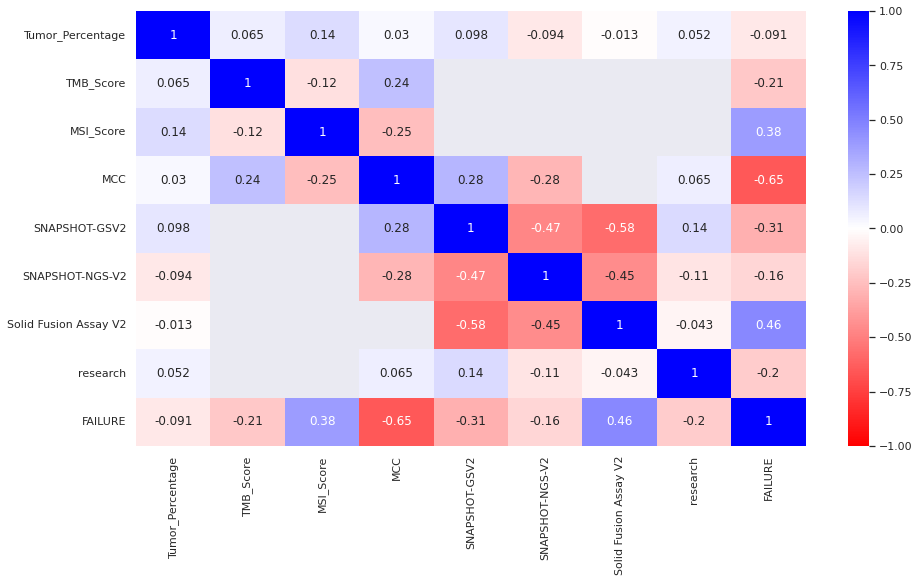

In [12]:
sns.heatmap(df.corr(), annot=True, cmap="bwr_r", vmin=-1, vmax=1)

In [13]:
model_columns = [
    'Results',
    'SNAPSHOT-GSV2',
    'SNAPSHOT-NGS-V2', 
    'Solid Fusion Assay V2', 
    'research', 
    'FAILURE',
]

In [14]:
index_column = "Results"
data = df[model_columns].set_index(index_column)

In [15]:
# Remove nans
data = data.dropna()

In [16]:
data_train = data.sample(int(0.8 * len(data)))
data_test = data.loc[data.index.symmetric_difference(data_train.index),]
assert len(data_train) + len(data_test) == len(data)

In [17]:
data = data.dropna()

In [18]:
target_column = "FAILURE"

X_train = data_train.drop(columns=[target_column])
X_test = data_test.drop(columns=[target_column])

y_train = data_train[target_column]
y_test = data_test[target_column]

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [20]:
max_depth = 5
random_state = 0
clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [21]:
X_train

,SNAPSHOT-GSV2,SNAPSHOT-NGS-V2,Solid Fusion Assay V2,research
Results,,,,
CID21-1102Results1,1,0,0,0
CID21-2698Results1,1,0,0,0
CID21-446Results1,1,0,0,0
CID20-1006Results1,0,1,0,0
CID21-512Results1,0,0,1,0
...,...,...,...,...
CID21-648Results1,0,0,1,0
CID21-1874Results1,1,0,0,0
CID20-990Results1,0,1,0,0


In [22]:
mlflow.log_param("max_depth", max_depth)
mlflow.log_param("random_state", random_state)

In [23]:
score = clf.score(X_test, y_test)
score

0.7011278195488722

In [24]:
mlflow.log_metric("score", score)

In [25]:
save_model(
    mlflow.sklearn,
    clf,
    "random_forest"
)

In [26]:
#mlflow.end_run()

In [27]:
df1 = pd.DataFrame([
    [1,2],
    [None,4],
    [5,6],
], columns = ["a", "b"])

df2 = pd.DataFrame([
    [10,20],
    [10,20],
    [10,20],
], columns = ["a", "d"])
df2

,a,d
0,10,20
1,10,20
2,10,20


In [28]:
df = df1.join(df2, lsuffix="_left", rsuffix="_right")
df

,a_left,b,a_right,d
0,1.0,2,10,20
1,NaN,4,10,20
2,5.0,6,10,20


In [29]:
df[order].bfill(axis=1).iloc[:, 0]

NameError: name 'order' is not defined

In [ ]:
order = ["a_left", "a_right"]
df["a"] = df[order].bfill(axis=1).iloc[:, 0]
df = df.drop(columns = order)
df

In [ ]:
(df1["a"] - df2["c"]).abs()

In [ ]:
set(df1.columns) - set(df2.columns)